# Sampling from k-DPPs: Fixed-Size Determinantal Point Processes
### Joanna Zou
#### Final Project for 18.338 Eigenvalues of Random Matrices, Fall 2024

In this project, we implement algorithms for sampling from a k-DPP, or determinantal point processes conditioned on sets of size $k$.

First, load all necessary packages: 

In [7]:
using LinearAlgebra, Random, Statistics, StatsBase, Distributions
using Combinatorics

include("plot_utils.jl")

potential_grid_2d (generic function with 1 method)

We consider a toy problem of drawing random subsets from a set of points distributed according to a Gaussian mixture model (GMM) with probability density function $p \in \mathcal{P}(\mathbb{R}^2)$: 

$$ p(x) = \sum_{i=1}^4 \frac{1}{4} g(x | \mu_i, \Sigma_i) $$

where $g(x|\mu, \Sigma)$ denotes the Gaussian probability density function $N(\mu, \Sigma)$. 

We choose for all Gaussians to have the same covariance, $\Sigma_i = \Sigma = 0.2 \mathbb{I}_2$ for all $i$, and the means to be $\mu_1 = [-1,-1], \mu_2 = [-1,1], \mu_3 = [1,1], \mu_4 = [1,-1]$. 


In [146]:
gmm = MixtureModel(MvNormal, [([-1,-1], 0.2*I(2)),
                              ([-1,1], 0.2*I(2)),
                              ([1,1], 0.2*I(2)),
                              ([1,-1], 0.2*I(2))], [0.25, 0.25, 0.25, 0.25])

N = 500 # number of samples
xsamp = [rand(gmm) for i=1:N]
xmat = reduce(hcat, xsamp)

2×500 Matrix{Float64}:
 -1.63478  -0.972599  0.746232   1.76208   …   0.0649095   1.57944  1.35731
  1.001    -0.830633  0.620897  -0.848782     -0.581544   -1.50788  0.814394

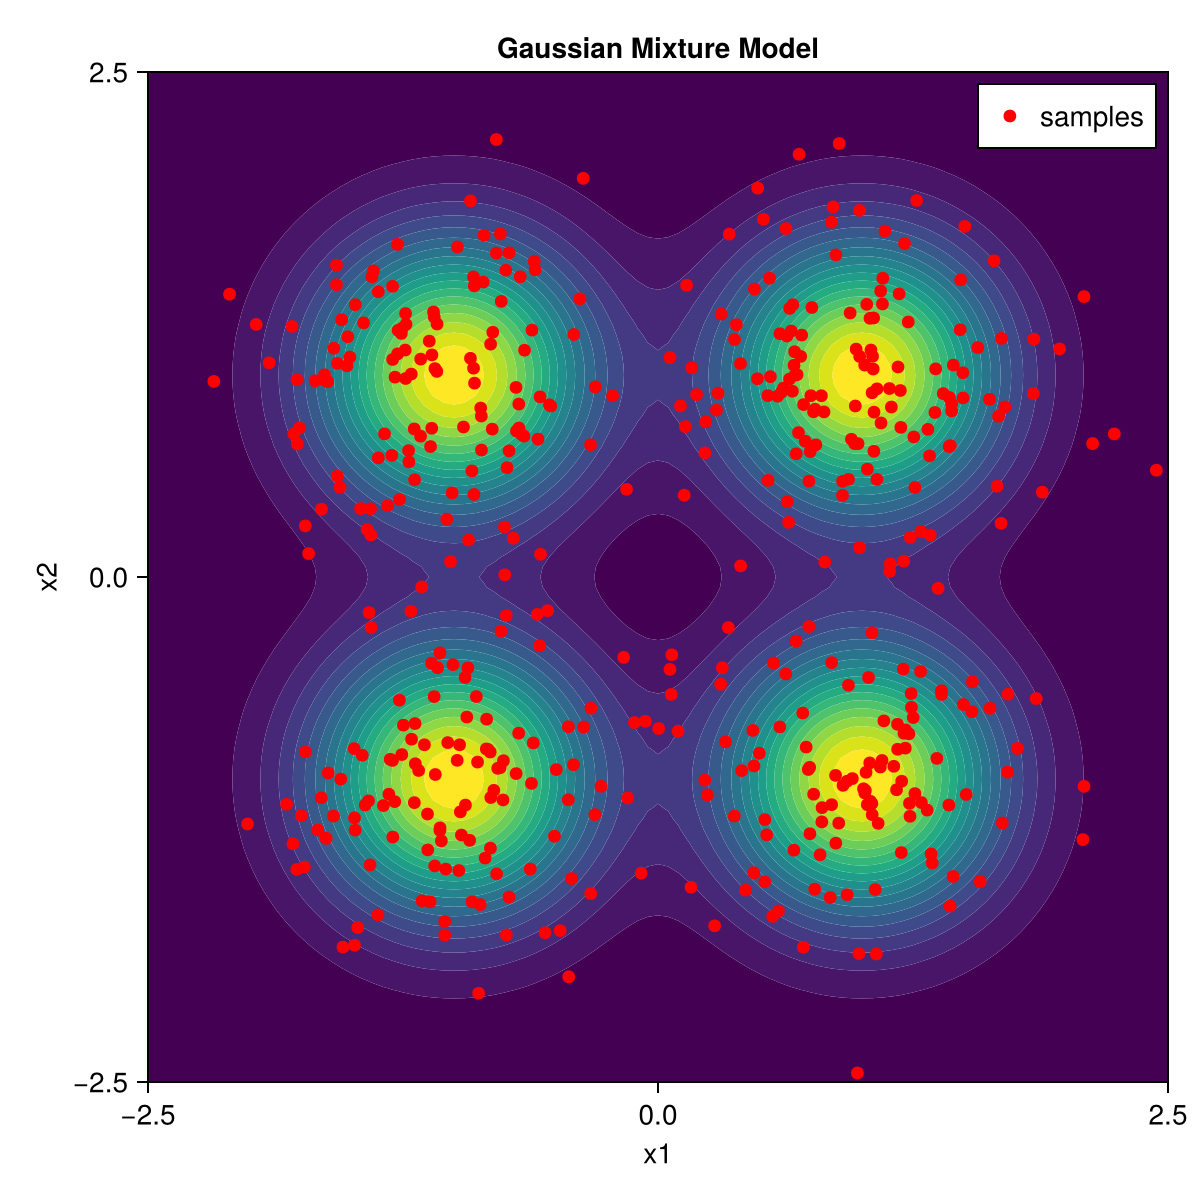

In [209]:
xgrid = [Vector(-2.5:0.05:2.5), Vector(-2.5:0.05:2.5)]
f, ax = plot_contours_2d(x -> pdf(gmm, x), xgrid, "pdf(x)", fill=true, ttl="Gaussian Mixture Model")
scatter!(ax, xmat[1,:], xmat[2,:], color=:red, label="samples")
axislegend(ax)
f

In [210]:
save("GMM.png", f)

CairoMakie.Screen{IMAGE}


We consider the problem where $\mathcal{Y}$ is a set of $N$ discrete samples from the GMM. We would like to select a random subset $Y_k \subseteq \mathcal{Y}$ with fixed cardinality $|Y_k| = k \leq N$.

To define the DPP, we choose a kernel function $\kappa: \mathbb{R}^2 \times \mathbb{R}^2 \to \mathbb{R}$ for computing the pairwise similarity between two elements in the set $\mathcal{Y}$ and constructing the $K$ matrix. In this case, we choose $\kappa$ to be the squared exponential kernel with length scale $\ell = 2$: 

$$ \kappa(x, y) = \exp \Big( -\frac{||x-y||^2}{2\ell^2} \Big) $$ 

In [265]:
κ(x,y; ℓ=2.5) = exp(-norm(x-y)^2 / (2*ℓ^2))
K = Hermitian(reduce(hcat, [[κ(xsamp[i],xsamp[j]) for i=1:N] for j=1:N]))

500×500 Hermitian{Float64, Matrix{Float64}}:
 1.0       0.738252  0.628075  0.302151  …  0.649552  0.264462  0.487243
 0.738252  1.0       0.66704   0.549743     0.912947  0.572509  0.521646
 0.628075  0.66704   1.0       0.774644     0.858297  0.658314  0.967666
 0.302151  0.549743  0.774644  1.0          0.789667  0.96327   0.791046
 0.451352  0.885399  0.455362  0.5088       0.781645  0.601614  0.345938
 0.634103  0.621192  0.993894  0.721772  …  0.80857   0.595692  0.970317
 0.666103  0.948502  0.473853  0.385182     0.758718  0.427982  0.341733
 0.380312  0.690022  0.787716  0.969036     0.890997  0.970479  0.754311
 0.259738  0.339248  0.793751  0.827938     0.576398  0.676132  0.904088
 0.422878  0.672314  0.874276  0.972721     0.895302  0.924502  0.855582
 ⋮                                       ⋱                      
 0.733751  0.609434  0.948987  0.583427     0.749369  0.467391  0.898642
 0.792229  0.968955  0.806779  0.631525     0.962755  0.617424  0.665622
 0.998869  0.7

Compute the corresponding L matrix: 

$$ L = K (I - K)^{-1} $$

In [266]:
L = Hermitian(K * inv(I - K))

500×500 Hermitian{Float64, Matrix{Float64}}:
 -0.0122889    -0.000151654   0.00328015   …  -0.0137331    0.00176139
 -0.000151654  -0.00605148   -0.00430703       0.00624699  -0.000820775
  0.00328015   -0.00430703   -0.00584104       0.00457528  -0.00470239
 -0.0169395     0.00302147    0.00193274      -0.00821779  -0.0107786
  0.006795     -0.00824768    0.011826        -0.0228399    0.0093411
  0.00311407   -0.00281657   -0.00540298   …   0.00638739  -0.00535597
 -0.010877     -0.010067      0.00726994       0.00872168  -0.0066601
 -0.00340913    0.000943199  -0.000272322     -0.011319    -0.00271341
 -0.0139239     0.00568534   -0.00337267      -0.0266268   -0.0156676
 -0.00397987   -0.00148383   -0.00207784      -0.01024     -0.00542826
  ⋮                                        ⋱               
 -0.000413201  -0.000364851  -0.00405021       0.0118645   -0.00380031
  0.00226895   -0.00544956   -0.00890821       0.00938758   2.0104e-6
 -0.0121295    -2.14278e-5    0.00268451      -

We now implement the sequential algorithm provided in Kulesza & Taskar (2011) for sampling the k-DPP.

In [126]:
function elementary_sym_poly(λ, k)
    N = length(λ)
    J_sets = collect(combinations(1:N, k))
    return sum([prod(λ[J]) for J in J_sets])
end

elementary_sym_poly (generic function with 1 method)

In [111]:
function elementary_sym_poly_grid(λ, k)
    N = length(λ)
    E = zeros(N+1,k+1)
    E[1:N+1,1] = ones(1:N+1)
    E
    for l = 2:k+1 
        for n = 2:N+1
            E[n,l] = E[n-1,l] + λ[n-1] * E[n-1, l-1]
        end
    end
    return E
end

elementary_sym_poly_grid (generic function with 1 method)

In [232]:
function rand_kDPP_seq(L::Hermitian, k::Integer)
    # calculate eigvals and eigvecs
    λ, Φ = eigen(L) 
    # calculate elementary symmetric polynomial coefficients
    ek = elementary_sym_poly_grid(λ, k)

    return rand_kDPP_seq(λ, Φ, k, ek)
end 

function rand_kDPP_seq(λ::Vector, Φ::Matrix, k::Integer, Emat::Matrix)
    N = length(λ)

    # calculate kth elementary symmetric polynomial coefficients
    ek = Emat[N+1, k+1] # elementary_sym_poly(λ, k)
    ek1 = Emat[N, k] # elementary_sym_poly(λ[1:end-1], k-1)

    # first loop - construct set
    J = Int64[]
    index = k
    for j = N:-1:1
        αj = λ[j] * ek1 / ek
        # sequentially sample index based on probabilities
        if rand(Uniform(0,1)) < αj
            push!(J, j)
            index -= 1
            if index != 0
                # update elem. sym. polys 
                ek = Emat[N+1, index+1]
                ek1 = Emat[N, index]
            else
                break
            end
        end
    end

    # second loop
    V = Φ[:,J]
    Y = Int64[]
    index_set = 1:N
    for m = 1:k
        norms = sum(V.^2, dims=2)
        probs = vec(norms) / sum(norms)
        # sample an index based on probabilities 
        yi = sample(1:size(V,1), Weights(probs))
        push!(Y, index_set[yi])
        # orthogonalize against selected item
        v_sel = V[yi,:]
        v_sel /= norm(v_sel) # normalize magitude
        for i in 1:size(V, 1)
            V[i, :] -= vec(v_sel' * V[i, :] * v_sel')
        end
        # remove vector 
        index_set = setdiff(index_set, index_set[yi])
        V = V[setdiff(1:end, yi), :]
    end

    # return index set
    return Y
end

rand_kDPP_seq (generic function with 2 methods)

Test the function for sampling subsets of $k$ indices for a number of trials.

In [267]:
k = 4 # subset size

# precompute eigendecomposition and elementary symmetric polynomials
λ, Φ = eigen(L) 
ek = elementary_sym_poly_grid(λ, k)

# draw samples from k-DPP
Ntrials = 10000
id_dpp = [rand_kDPP_seq(λ, Φ, k, ek) for i=1:Ntrials]

10000-element Vector{Vector{Int64}}:
 [1, 2, 3, 4]
 [1, 2, 3, 4]
 [1, 2, 3, 4]
 [407, 1, 2, 3]
 [1, 2, 3, 4]
 [150, 363, 210, 292]
 [1, 2, 3, 4]
 [499, 416, 300, 232]
 [1, 2, 3, 4]
 [373, 1, 2, 3]
 ⋮
 [1, 2, 3, 4]
 [1, 2, 3, 4]
 [1, 2, 3, 4]
 [1, 2, 3, 4]
 [1, 2, 3, 4]
 [1, 2, 3, 4]
 [1, 2, 3, 4]
 [1, 2, 3, 4]
 [1, 2, 3, 4]

For a number of trials, plot the points which are selected to visualize their relative locations.

In [268]:
Y_dpp = [reduce(hcat, xsamp[ids]) for ids in id_dpp]

10000-element Vector{Matrix{Float64}}:
 [-1.6347798157959275 -0.9725987899525131 0.7462324379030618 1.7620797478820658; 1.0010038907277765 -0.8306332235542282 0.6208968753038677 -0.8487815416827811]
 [-1.6347798157959275 -0.9725987899525131 0.7462324379030618 1.7620797478820658; 1.0010038907277765 -0.8306332235542282 0.6208968753038677 -0.8487815416827811]
 [-1.6347798157959275 -0.9725987899525131 0.7462324379030618 1.7620797478820658; 1.0010038907277765 -0.8306332235542282 0.6208968753038677 -0.8487815416827811]
 [-2.0120219844177294 -1.6347798157959275 -0.9725987899525131 0.7462324379030618; -1.2225271525981096 1.0010038907277765 -0.8306332235542282 0.6208968753038677]
 [-1.6347798157959275 -0.9725987899525131 0.7462324379030618 1.7620797478820658; 1.0010038907277765 -0.8306332235542282 0.6208968753038677 -0.8487815416827811]
 [-1.748220256928482 -1.129925155440953 1.5041303332989602 1.3349132562121642; -1.1809923341323247 -1.1733054966177918 1.7353607805651832 0.20793949057907712]
 

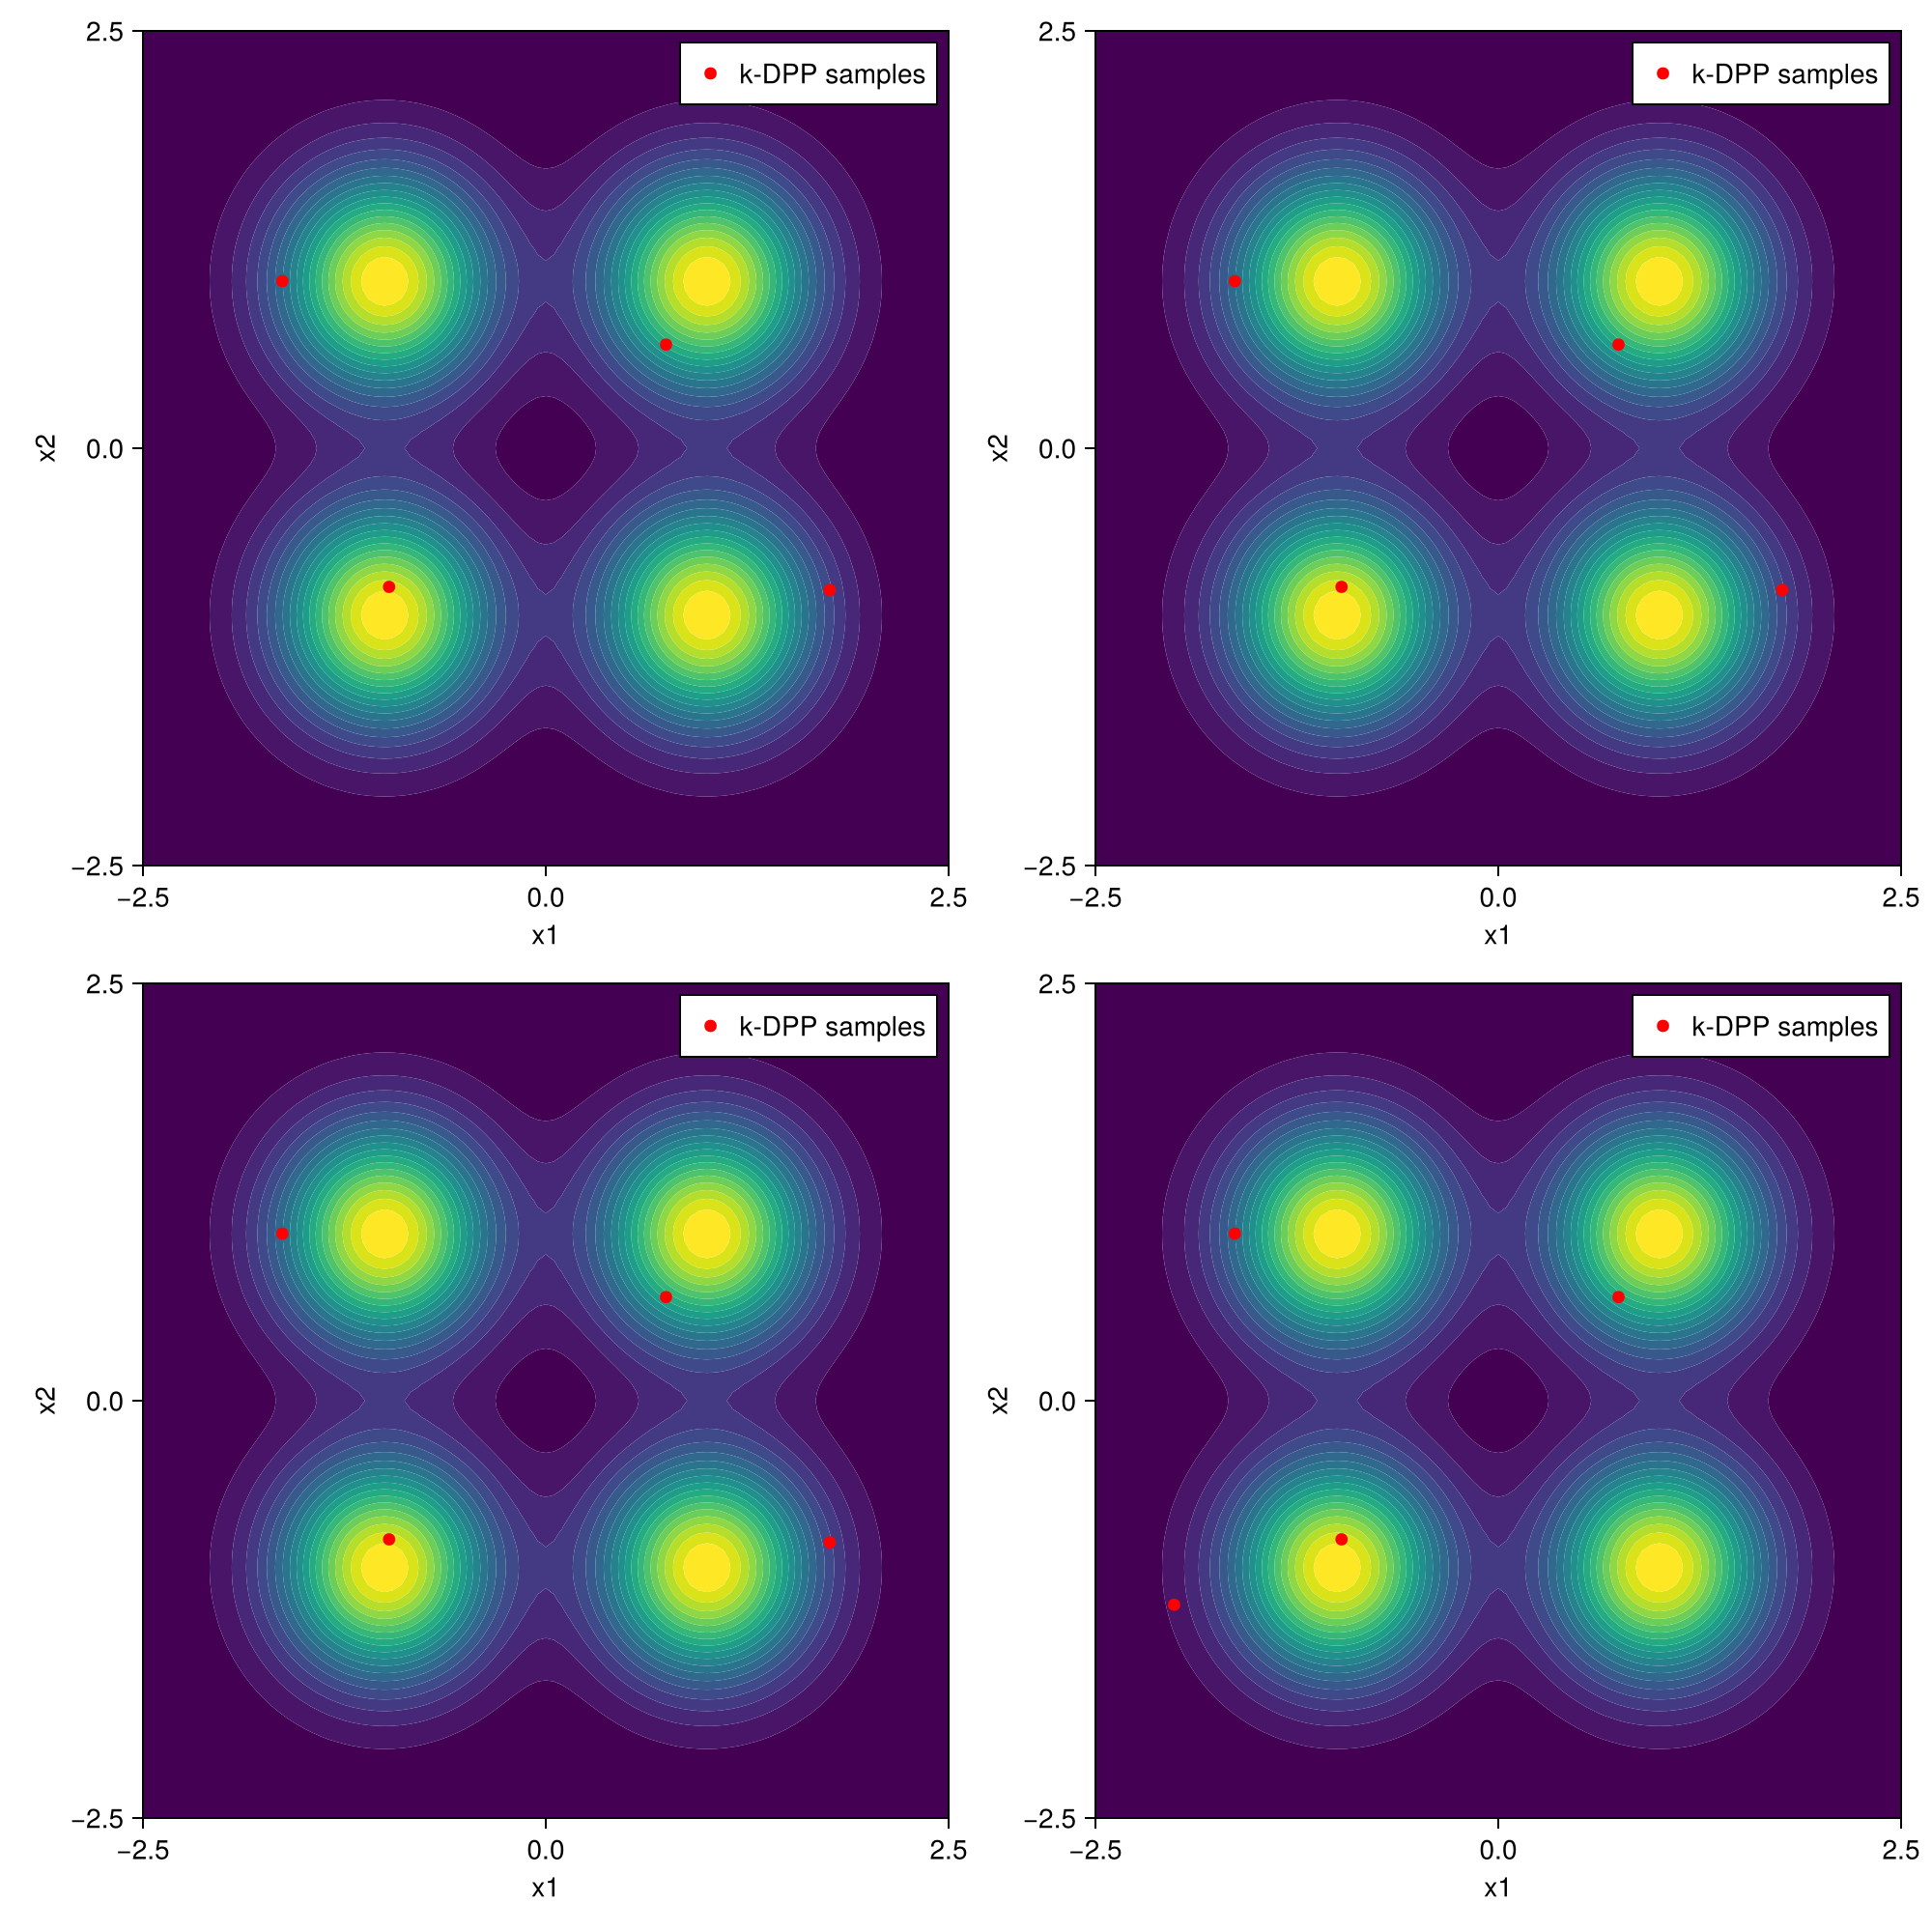

In [269]:
f = Figure(size=(1000,1000))
axs = Vector{Axis}(undef, 4)
ids1 = [1,1,2,2]; ids2 = [1,2,1,2]

for k = 1:4
    axs[k] = Axis(f[ids1[k], ids2[k]], xlabel="x1", ylabel="x2", limits=(-2.5, 2.5, -2.5, 2.5))
    plot_contours_2d!(axs[k], x -> pdf(gmm, x), xgrid, "pdf(x)", fill=true)
    scatter!(axs[k], Y_dpp[k][1,:], Y_dpp[k][2,:], color=:red, label="k-DPP samples")
    axislegend(axs[k])
end
f

We observe that the subsets drawn enforce large distances between the points, as a result of the "repulsive" or "diversity-promoting" behavior of DPP subsets. We can quantify this by comparing the mean distance between points drawn with a k-DPP with those drawn with simple random sampling (SRS).

In [270]:
id_rand = [sample(1:N, k) for i=1:Ntrials]
Y_rand = [reduce(hcat, xsamp[ids]) for ids in id_rand]

10000-element Vector{Matrix{Float64}}:
 [1.4272856212106044 0.562211696538131 0.7629686400404759 -0.8196963012051932; 0.6453768568039591 -1.6799035013994268 -1.0753307635574003 -1.0919421135326381]
 [-0.7925078571238813 0.4707378398803247 -0.7302459844464895 -1.55505718400051; 2.1659588488048103 -0.9353452084471126 0.6243566710702051 -1.0005071692294742]
 [1.5413894553190852 -0.902060205135491 -0.9192181627626738 -0.4987025987588757; -0.5183856849360677 0.40872733139850514 1.8616463485755972 -0.9534437876075309]
 [-0.5413907801157214 1.2424209956999073 -1.1450849999936898 1.2302697871658352; -0.1666537864257377 -0.6452283190391384 -0.83065221947982 -0.7763603712034384]
 [1.319486409481755 0.8717857207674117 -0.33062692743242905 -1.3126910390148683; -1.1539460840060005 -1.3177894408899822 0.654513056097184 -0.9026556844849486]
 [-1.0618778618803817 -0.6830377517314323 0.6275872237300335 -0.6178965517771408; -1.3062509733227161 -0.7731852469248184 1.7250619056416499 1.2220527151406209]
 

In [162]:
function mean_euclid_distance(m::Matrix)
    total_dist = 0
    d, n = size(m)
    for i = 1:n-1
        for j = i+1:n 
            total_dist += norm(m[:,i] - m[:,j])
        end
    end
    return total_dist ./ n
end


mean_euclid_distance (generic function with 2 methods)

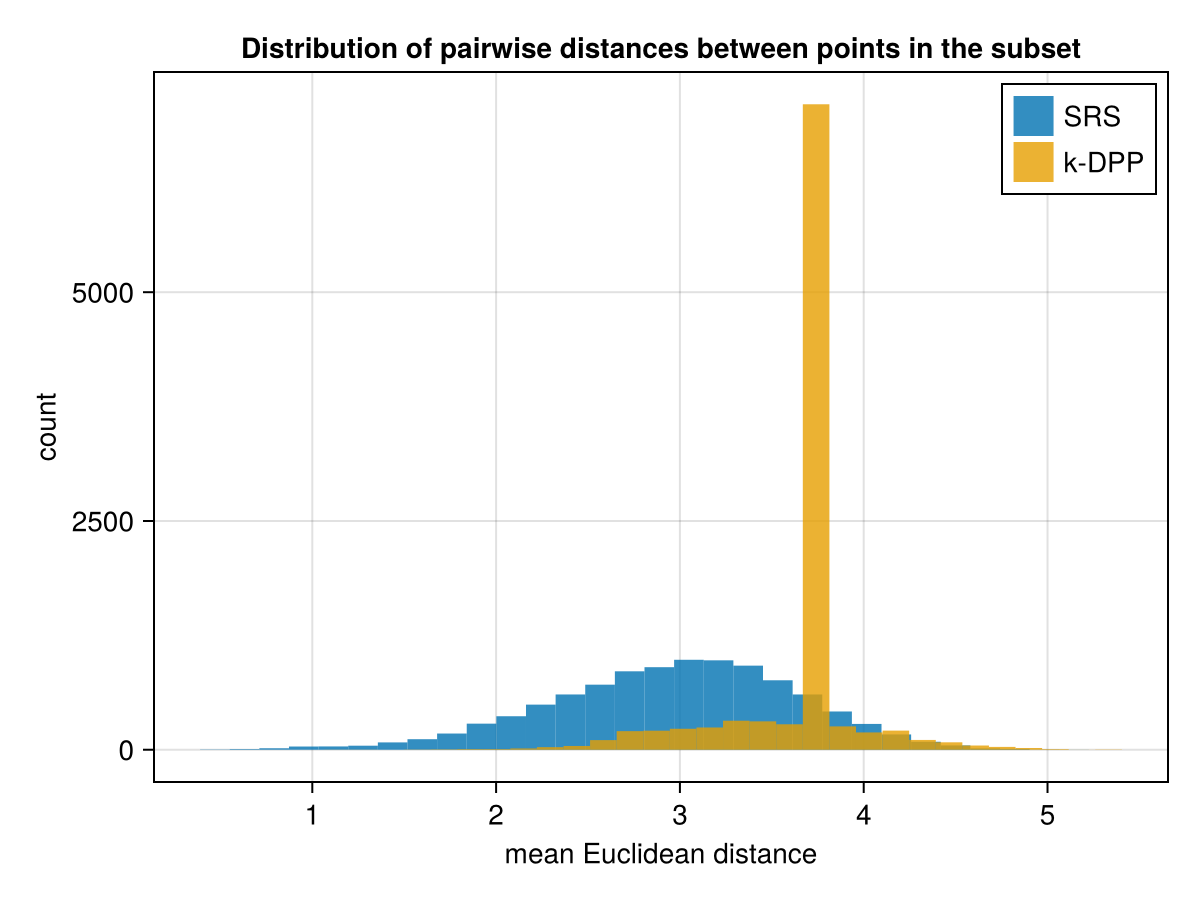

In [271]:
dist_rand = [mean_euclid_distance(Y) for Y in Y_rand]
dist_dpp = [mean_euclid_distance(Y) for Y in Y_dpp]

fig = Figure()
ax = Axis(fig[1,1], xlabel="mean Euclidean distance", ylabel="count", title="Distribution of pairwise distances between points in the subset")
hist!(ax, dist_rand, bins=30, label="SRS")
hist!(ax, dist_dpp, bins=30, label="k-DPP")
axislegend(ax)
fig

The mean Euclidean distance between points selected by the k-DPP is on average higher than those selected with SRS, and with significantly reduced variance. 

We notice that certain samples are drawn more often than others, leading to the sharply peaked DPP mode. To investigate this further, we can quantify the probability of a single element being included in the k-DPP set, referred to as the *inclusion probability*. 

In [238]:
function compute_inclusion_prob(i::Integer, k::Integer, λ::Vector)
    N = length(λ)
    e_num = elementary_sym_poly_grid(λ[setdiff(1:N, i)], k-1)[end,end]
    e_denom = elementary_sym_poly_grid(λ, k)[end, end]
    return λ[i] * e_num / e_denom
end

compute_inclusion_prob (generic function with 2 methods)

In [272]:
incl_prob = [compute_inclusion_prob(i, k, λ) for i=1:N]

500-element Vector{Float64}:
  0.9030396670822792
  0.8853084978632698
  0.7908381278685589
  0.7496709198836233
  0.7490932270885307
  0.7426972661980435
  7.373605241596461e-14
  1.8247951458769857e-14
  1.7186281237008937e-14
  1.2396670052324863e-14
  ⋮
 -0.010181953044807372
 -0.012362650470443359
 -0.019821085880497084
 -0.027673159339783444
 -0.04041167217648465
 -0.24746350006187276
 -0.2920902376271044
 -0.31774982575370464
  0.1540773233893313

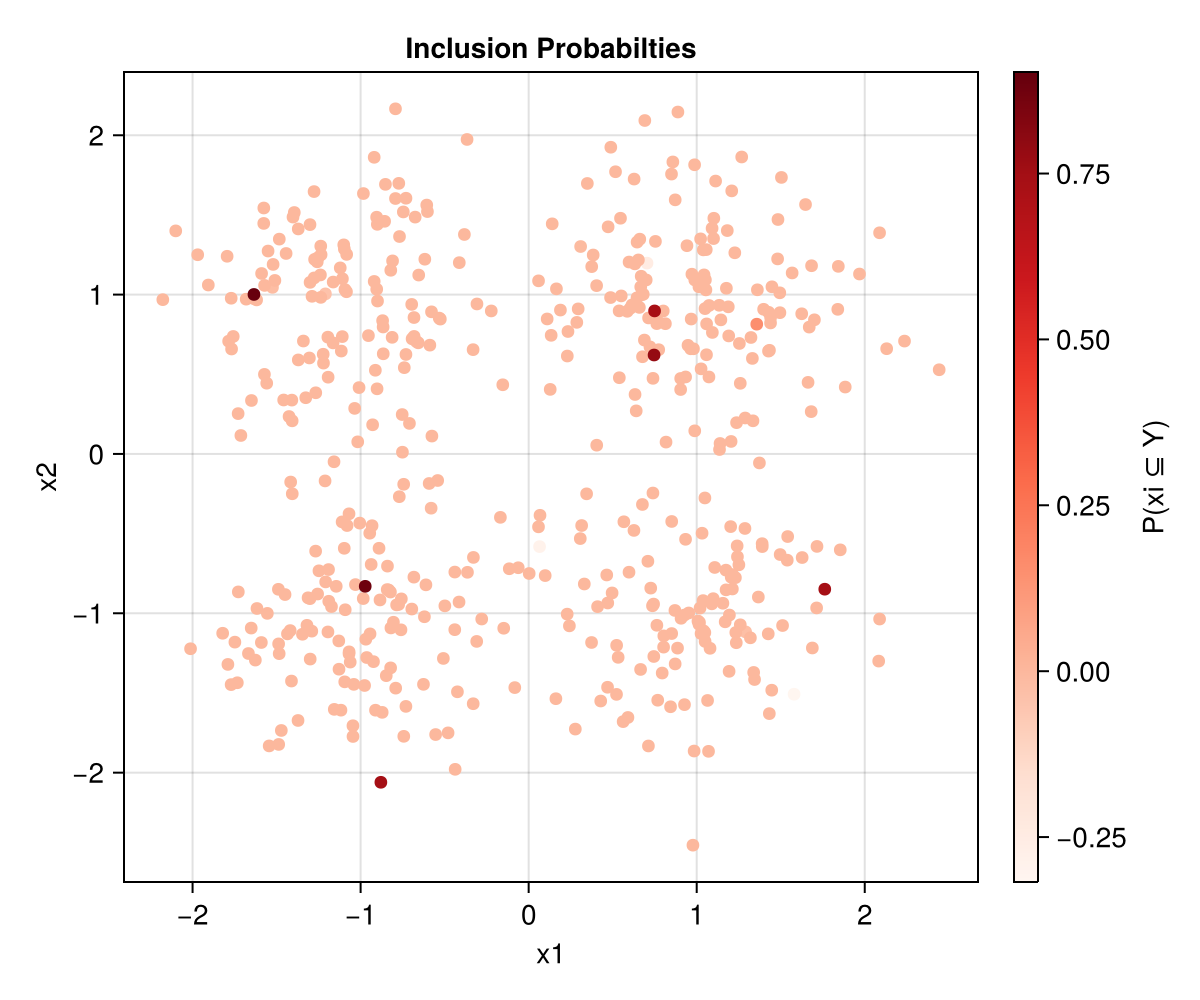

In [273]:
fig = Figure(size=(600,500))
ax = Axis(fig[1,1][1,1], xlabel="x1", ylabel="x2", title="Inclusion Probabilties")
sc = scatter!(ax, xmat[1,end:-1:1], xmat[2,end:-1:1], color=incl_prob[end:-1:1], colormap=:Reds)
Colorbar(fig[1, 1][1, 2], sc, label="P(xi ⊆ Y)")
fig